<a href="https://colab.research.google.com/github/adnanq2004/distracted_driving/blob/main/Distracted_Driving_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](http://static1.squarespace.com/static/56ccc8724c2f8548059fbcfe/58f6daea15d5dbcc64ef63aa/5cae2d770d92977242838baa/1557942174418/SW-DistractedDriving-Clean-1.jpg?format=1500w)

In [ ]:
#@title Re-import some libraries
! pip3 install scipy==1.1.0 ### NOTE: YOU MAY NEED TO REINSTALL 

In [ ]:
# RUN THE CODE BLOCK ABOVE, THEN RESTART THE RUNTIME.
# THEN, THE FOLLOWING IMPORT STATEMENT WILL WORK.
! pip install git+https://github.com/raghakot/keras-vis.git -U

!pip uninstall -y keras-nightly
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.15.4
!pip install keras==2.2.4

from vis.visualization import visualize_saliency, visualize_cam

  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-go3rkcci
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-go3rkcci


Using TensorFlow backend.


In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }


import cv2
import numpy as np

def label_to_numpy(labels):
  final_labels = np.zeros((len(labels), 4))
  for i in range(len(labels)):
    label = labels[i]
    if label == 'Attentive':
      final_labels[i,:] = np.array([1, 0, 0, 0])
    if label == 'DrinkingCoffee':
      final_labels[i,:] = np.array([0, 1, 0, 0])
    if label == 'UsingMirror':
      final_labels[i,:] = np.array([0, 0, 1, 0])
    if label == 'UsingRadio':
      final_labels[i,:] = np.array([0, 0, 0, 1])
  return final_labels

def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)
    
def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)
  
def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data
  
class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):  
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of? 
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    metadata = metadata[keep_idx]
    
    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])
    
    metadata = pd.concat( [metadata_train, metadata_test] )
    
    return metadata

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True 
    '''
    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])
    
    metadata = pd.concat( [metadata_train, metadata_test] )
    
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)
  
class helpers:
  #### PLOTTING
  def plot_image(data, num_ims, figsize=(8,6), labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    print(data.shape)
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(-1,image_shape[0],image_shape[1],image_shape[2])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels      
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    
    nrows=int(np.sqrt(num_ims))
    ncols=int(np.ceil(num_ims/nrows))
    print(nrows,ncols)
    count=0
    if nrows==1 and ncols==1:
      print('Label: %s'%label)
      plt.imshow(image)
      plt.show()
    else:
      print(labels)
      fig = plt.figure(figsize=figsize)
      for i in range(nrows):
        for j in range(ncols):
          if count<num_ims:
            fig.add_subplot(nrows,ncols,count+1)
            plt.imshow(image[count])
            count+=1
      fig.set_size_inches(18.5, 10.5)
      plt.show()

    

  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))

    for layer in model.layers:
      if hasattr(layer,"activation"):
        stringlist.append(str(layer.activation))
        
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry. 
    history = history.history
    history.update({'epoch':list(range(len(history['val_acc'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_acc', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_acc', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'acc', data = history, label = 'Training', ax = ax)
    ax.axhline(0.25, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.01, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 0.5):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params, dropout = 0.5):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) 

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = tensorflow.keras.optimizers.RMSprop(lr=1e-4)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])    
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16, 
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet', 
                                              include_top = False, 
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable
      
    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'], 
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from imgaug import augmenters 

### defining project variables
# file variables
# image_data_url       = 'https://drive.google.com/uc?id=1qmTuUyn0525-612yS-wkp8gHB72Wv_XP'
# metadata_url         = 'https://drive.google.com/uc?id=1OfKnq3uIT29sXjWSZqOOpceig8Ul24OW'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 4
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'

###
!wget -O metadata.csv 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/metadata%20(1).csv'
!wget -O image_data.npy 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/image_data%20(1).npy'
# gdown.download(image_data_url, image_data_path , True)
# gdown.download(metadata_url, metadata_path , True)


### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_image = lambda data, num_ims,figsize=(8,6), labels = [], index = None: helpers.plot_image(data = data, num_ims=num_ims, figsize=figsize,labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

#monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

--2022-01-03 15:54:42--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/metadata%20(1).csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.132.128, 74.125.201.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205142 (200K) [text/csv]
Saving to: ‘metadata.csv’

metadata.csv        100%[===================>] 200.33K  --.-KB/s    in 0.004s  

2022-01-03 15:54:42 (47.7 MB/s) - ‘metadata.csv’ saved [205142/205142]

--2022-01-03 15:54:42--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/image_data%20(1).npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting t

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 6724 samples, validate on 920 samples
Epoch 1/50
6724/6724 [==============================] - 2s 287us/sample - loss: 1.3910 - acc: 0.3000 - val_loss: 1.3737 - val_acc: 0.3337
Epoch 2/50
6724/6724 [==============================] - 1s 175us/sample - loss: 1.2921 - acc: 0.3910 - val_loss: 1.3690 - val_acc: 0.3370
Epoch 3/50
6724/6724 [==============================] - 1s 163us/sample - loss: 1.1973 - acc: 0.4802 - val_loss: 1.3919 - val_acc: 0.3022
Epoch 4/50
6724/6724 [==============================] - 1s 165us/sample - loss: 1.0735 - acc: 0.5583 - val_loss: 1.4233 - val_acc: 0.3163
Epoch 5/50
6724/6724 [==============================] - 1s 164us/sample - loss: 0.9513 - acc: 0.6267 - val_loss: 1.4351 - val_acc: 0.3283
Epoch 6/50
6724/6724 [==============================] - 1s 168us/sample - loss: 0.8560 - acc: 0.6706 - val_loss: 1.5500 - val_acc: 0.3750
Epoch 7/50
6724/6724 [======================

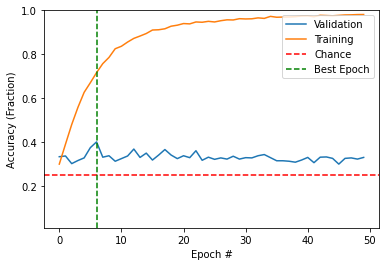

CNN


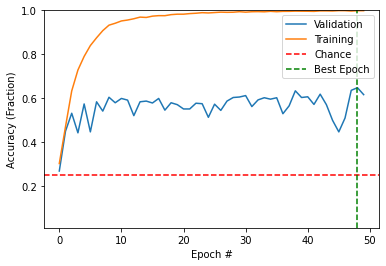

In [ ]:
train_data, train_labels = get_train_data(flatten=True)
test_data, test_labels = get_test_data(flatten=True)

train_data = train_data.reshape([-1, 64, 64, 3])
test_data = test_data.reshape([-1, 64, 64, 3])

train_labels = label_to_numpy(train_labels)
test_labels = label_to_numpy(test_labels)

dense = DenseClassifier(hidden_layer_sizes = (128,64))
cnn = CNNClassifier(num_hidden_layers = 5)

dense.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
cnn.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

print('Dense')
plot_acc(dense.history)

print('CNN')
plot_acc(cnn.history)

In [ ]:
## Choose a random image to visualize.
IMAGE_INDEX = 777
img = test_data[IMAGE_INDEX]

In [ ]:
# Initialize Keras and Tensorflow sessions
import keras
import tensorflow as tf
session = keras.backend.get_session()
init = tf.global_variables_initializer()
session.run(init)

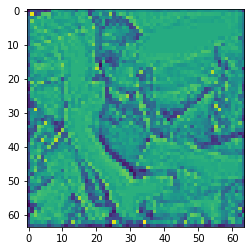

In [ ]:
# Visualize the 1st layer (the second argument of the function).
LAYER_TO_VISUALIZE = 1
saliency_map = visualize_saliency(cnn, LAYER_TO_VISUALIZE, filter_indices = None, seed_input=img)
plt.imshow(saliency_map)

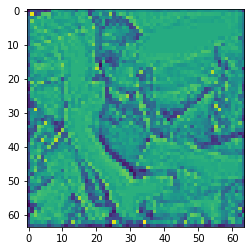

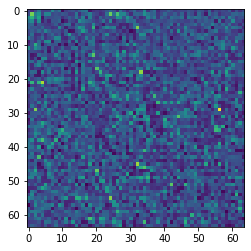

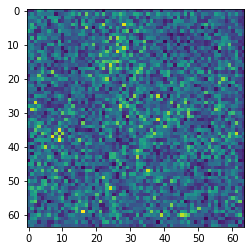

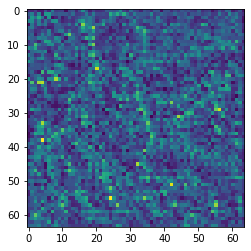

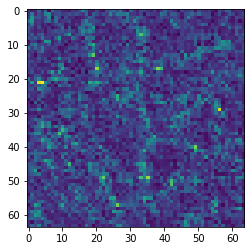

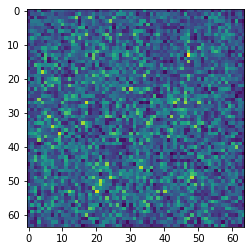

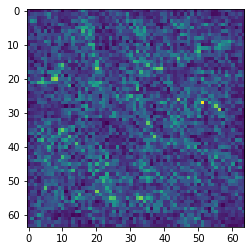

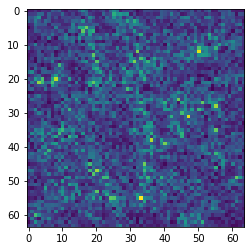

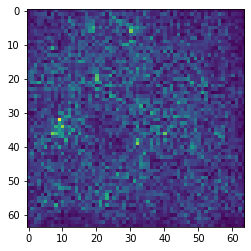

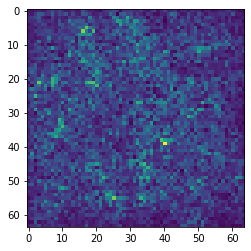

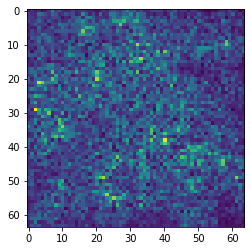

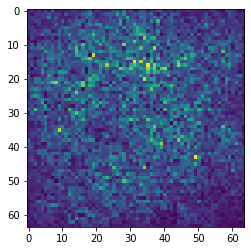

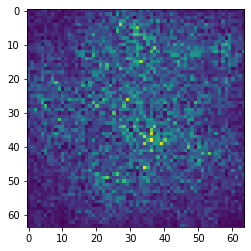

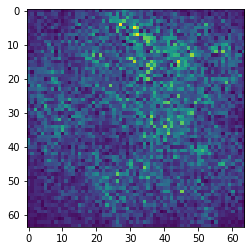

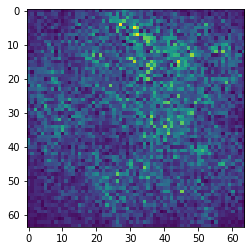

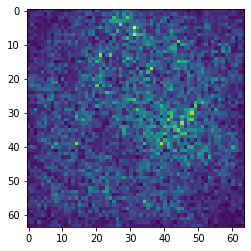

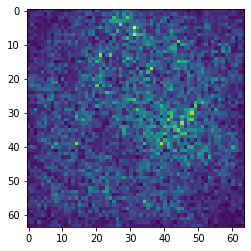

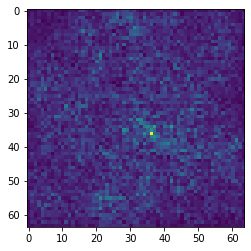

In [ ]:
for i in range(18):
  LAYER_TO_VISUALIZE = i+1
  saliency_map = visualize_saliency(cnn, LAYER_TO_VISUALIZE, filter_indices = None, seed_input=img)
  plt.imshow(saliency_map)
  plt.show()

58892288/58889256 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6724 samples, validate on 920 samples
Epoch 1/15
6724/6724 [==============================] - 11s 2ms/sample - loss: 1.3899 - acc: 0.2748 - val_loss: 1.3638 - val_acc: 0.3261
Epoch 2/15
6724/6724 [==============================] - 9s 1ms/sample - loss: 1.3582 - acc: 0.3261 - val_loss: 1.3422 - val_acc: 0.4707
Epoch 3/15
6724/6724 [==============================] - 9s 1ms/sample - loss: 1.3352 - acc: 0.3769 - val_loss: 1.3121 - val_acc: 0.4587
Epoch 4/15
6724/6724 [==============================] - 9s 1ms/sample - loss: 1.3027 - acc: 0.4115 - val_loss: 1.2819 - val_acc: 0.4739
Epoch 5/15
6724/6724 [==============================] - 9s 1ms/sample - loss: 1.2503 - acc: 0.4628 - val_loss: 1.2512 - val_acc: 0.4685
Epoch 6/15
6724/6724 [==============================] - 9s 1ms/sample - loss: 1.2034 - acc: 0.5015 - val_loss: 1.

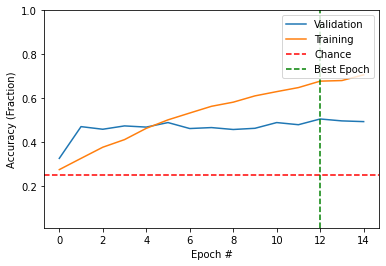

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))

for layer in vgg_expert.layers:
  layer.trainable = False

vgg_model = Sequential()
vgg_model.add(vgg_expert)

vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(4, activation = 'sigmoid'))

vgg_model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizers.SGD(learning_rate = 1e-4, momentum = 0.95),
                  metrics = ['accuracy'])

history = vgg_model.fit(train_data, train_labels, epochs = 15, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
plot_acc(history)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
predictions = vgg_model.predict_classes(test_data)

In [ ]:
# accuracy = accuracy_score(predictions, test_layer)
final_labels = []
for label in test_labels:
 if label[0]==1:
    final_labels.append(0)
 else:
  final_labels.append(1)
# Now, we change our final predictions to 0 and 1. That is, if the predictions
# currently is 0, then add 0 (for attentive) to binary_predictions. Otherwise,
# add 1. 
binary_predictions = []
for label in predictions:
  if label==1:
    binary_predictions.append(0)
  else:
    binary_predictions.append(1)

print('Accuracy is %d %%'%(accuracy_score(final_labels, binary_predictions)*100.0))

Accuracy is 62 %


In [ ]:
confusion = confusion_matrix(final_labels, binary_predictions)
print(confusion)

tp  = confusion[1][1]
tn  = confusion[0][0] 
fp = confusion[0][1]
fn = confusion[1][0]

print('True positive: %d'%tp)
print('True negative: %d'%tn)
print('False positive: %d'%fp)
print('False negative: %d'%fn)

[[ 11 219]
 [125 565]]
True positive: 565
True negative: 11
False positive: 219
False negative: 125


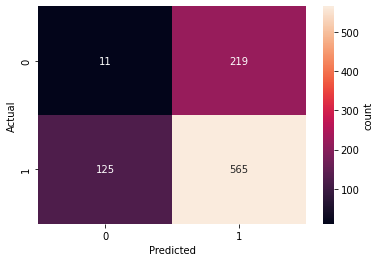

In [ ]:
# grab our plotting package
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');

In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(precision)
print(recall)

0.7206632653061225
0.8188405797101449
